# 导入包

In [7]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import os
from tqdm import tqdm

# Q网络

In [8]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Dueling Q网络

In [92]:
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(-1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q

# DQN算法

In [93]:
class DQN:
    ''' DQN算法,包括Double DQN '''

    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  #======># Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(state, dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        
        # ======> # 下个状态的最大Q值, Double DQN的区别
        if self.dqn_type == 'DoubleDQN' or 'DuelingDQN':  # 先在q网络确定动作, 再对应到目标网络的价值上
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:  # DQN的情况, 直接用目标网络估计价值
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
            
        q_targets = rewards + self.gamma * max_next_q_values * (1 - (dones.int() | truncated.int()))  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step() # 执行Adam梯度下降

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

# 初始化参数

In [94]:
# 环境相关
CKP_PATH = None # 后面确定路径
env_name = 'Pendulum-v1'
env = gym.make(env_name, render_mode='rgb_array')

# DQN相关
total_epoch = 10  # 迭代数
s_epoch = 0 # 默认开始位置
total_episode = 100  # 每次迭代最大游戏轮数
gamma = 0.98
epsilon = 1  # 刚开始随机动作,更新中线性降低
target_update = 50  # 若干回合更新一次目标网络
buffer_size = 5000  # 经验大小
minimal_size = 1000  # 最小经验数
batch_size = 128
best_score = 0  # 每回合中的最佳分数
reward_list = []
best_weight = 0

# 神经网络相关
lr = 2e-3
hidden_dim = 128
state_dim = env.observation_space.shape[0]  # 状态空间大小
action_dim = 11  # 将连续动作分成11个离散动作
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device:', device)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

# 随机数种子
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device: cuda


# 离散转连续

In [95]:
def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

# 训练函数

In [96]:
def train_DQN(agent, env, total_epoch, total_episode, replay_buffer, minimal_size, batch_size):
    best_score = -100  # 初始化最佳分数
    reward_list = [] 
    max_q_value_list = []
    max_q_value = 0
    for epoch in range(s_epoch, total_epoch):
        with tqdm(total=total_episode, desc='<%d/%d>'%(epoch+1, total_epoch), leave=False) as pbar:
            for episode in range(total_episode):
                episode_return = 0
                state = env.reset()[0]
                done = truncated = False
                while not (done | truncated):
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理, 主要保留前一状态
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    next_state, reward, done, truncated, info = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done, truncated)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d, b_t = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d,
                            'truncated' : b_t,
                        }
                        agent.update(transition_dict)
                        
                    if episode_return > best_score:
                        best_weight = agent.q_net.state_dict()
                        best_score = episode_return
                        
                reward_list.append(episode_return)
                
                if (episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'train_times':
                        '%d' % (total_episode * epoch + episode + 1),
                        'recent_reward:':
                        '%.3f' % np.mean(reward_list[-10:]),
                        'episilon':
                        '%.2f' % agent.epsilon
                    })
                    
                # 调整epsilon
                agent.epsilon = max(1 - epoch / (total_epoch / 3), 0.01)
                
                # 保存检查点
                torch.save({
                'epoch': epoch,
                'episode': episode,
                'best_weight': best_weight,
                'epsilon': epsilon,
                'reward_list': reward_list,
                }, CKP_PATH)
                
                pbar.update(1) # 更新进度条
                
    agent.q_net.load_state_dict(best_weight)  # 应用最佳权重
    return reward_list, max_q_value_list

# 读取检查点

In [97]:
def read_ckp(CKP_PATH):
    if os.path.exists(CKP_PATH):
        checkpoint = torch.load(CKP_PATH)
        s_epoch = checkpoint['epoch']
        epsilon = checkpoint['epsilon']
        agent.q_net.load_state_dict(checkpoint['best_weight'])
        reward_list = checkpoint['reward_list']
    else:
        s_epoch = 0

# 训练普通DQN

In [74]:
read_ckp('checkpoints/ckpt_dqn.pt')
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
reward_list, max_q_value_list = train_DQN(agent=agent, env=env, total_epoch=total_epoch, total_episode=total_episode,
                                          replay_buffer=replay_buffer, minimal_size=minimal_size,
                                          batch_size=batch_size)

## 作图

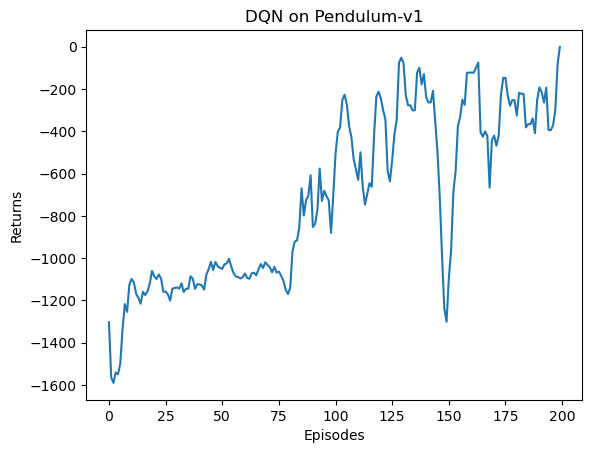

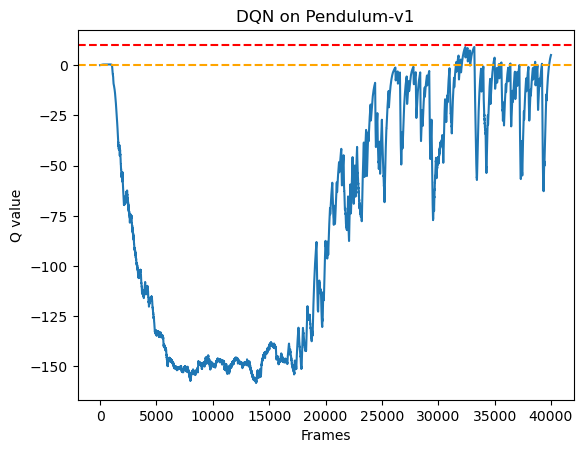

In [75]:
episodes_list = list(range(len(reward_list)))
mv_return = rl_utils.moving_average(reward_list, 5)

plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

## 🎉 评价

最大奖励是0，但是Q值多次大于0，甚至有到10的，是由argmax选择动作造成的过拟合的情况，Double DQN改善了此问题。

此外多次Q值低于-50，说明不稳定性很大，而Double DQN也有此问题，Dueling DQN则改善了此问题。

## 演示

In [51]:
def show_gym_policy(name, model, render_mode="human", epochs=10, steps=300):
    env = gym.make(name, render_mode=render_mode)
    env.reset()
    totals = []

    for i in range(epochs):  # 测试轮数
        episode_rewards = 0
        obs = env.reset()[0]  # 第二个输出为info，可以不要
        for _ in range(steps):  # 每回合最多300步
            try:
                Q_values = model(torch.tensor(obs).to('cuda'))
                action = np.argmax(Q_values.tolist())
                obs, reward, done, truncated, info = env.step([dis_to_con(action, env, agent.action_dim)])
                episode_rewards += reward
            except:
                env.close()
            if done or truncated:
                break
        totals.append((episode_rewards))
    env.close()
    return totals

In [54]:
show_gym_policy(env_name, agent.q_net)

[-238.01666589170281,
 -127.97067787302136,
 -239.58886993548853,
 -517.6151866464927,
 -3.7420484544063317,
 -124.13917652548557,
 -126.06749475689074,
 -121.8245985928503,
 -4.762697646898301,
 -244.991032523696]

# 训练Double DQN

In [77]:
CKP_PATH = 'checkpoints/ckpt_Double_dqn.pt'
read_ckp(CKP_PATH)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DoubleDQN')
reward_list, max_q_value_list = train_DQN(agent=agent, env=env, total_epoch=total_epoch, total_episode=total_episode,
                                          replay_buffer=replay_buffer, minimal_size=minimal_size,
                                          batch_size=batch_size)

## 作图

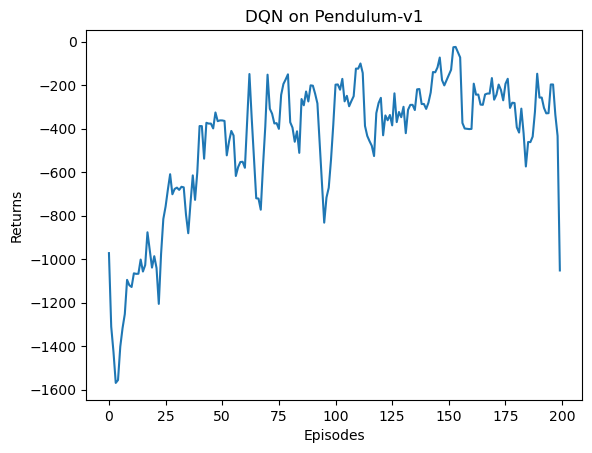

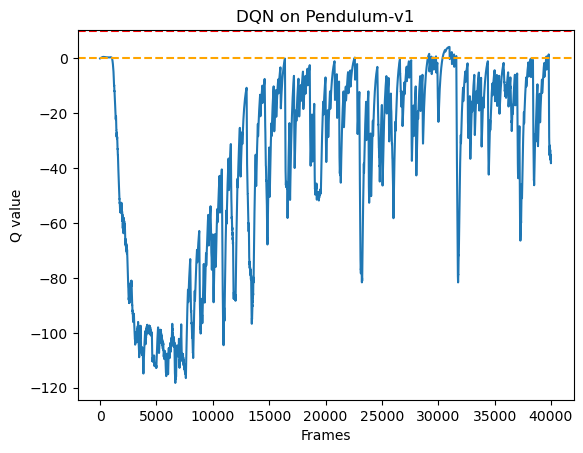

In [79]:
episodes_list = list(range(len(reward_list)))
mv_return = rl_utils.moving_average(reward_list, 5)

plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {} by avg_5'.format(env_name))
plt.show()

## 🎉 评价

Double DQN中动作的选取依靠目标网络，目标网络的参数更新有延迟，而前面得到的动作的Q值的估计还是依据原网络，普通DQN的动作是从原网络中选取的，会导致一直累积Q值比较高的动作的Q值，造成估计偏高。

但是Double DQN也存在比较严重的不稳定，有时候Q值会大幅下降，这是因为每次只更新一种状态动作的Q值，该状态下其他动作的Q值不考虑，普通DQN也有此问题。

# 训练Dueling DQN

In [100]:
CKP_PATH = 'checkpoints/ckpt_Dueling_dqn.pt'
read_ckp(CKP_PATH)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DuelingDQN')
reward_list, max_q_value_list = train_DQN(agent=agent, env=env, total_epoch=total_epoch, 
                                          total_episode=total_episode, replay_buffer=replay_buffer, minimal_size=minimal_size, batch_size=batch_size)

## 作图

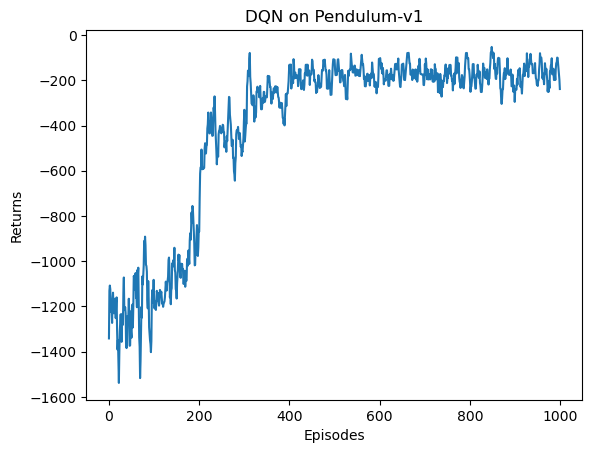

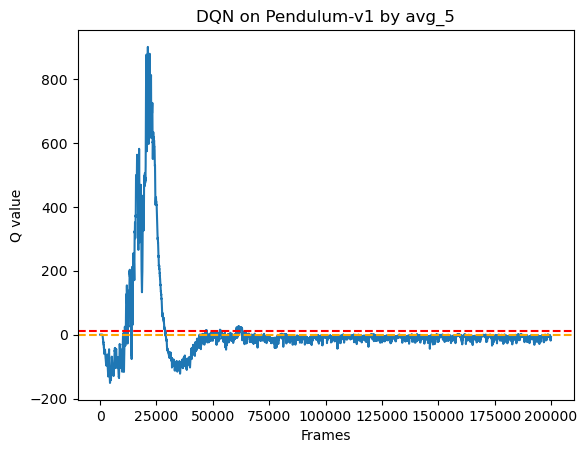

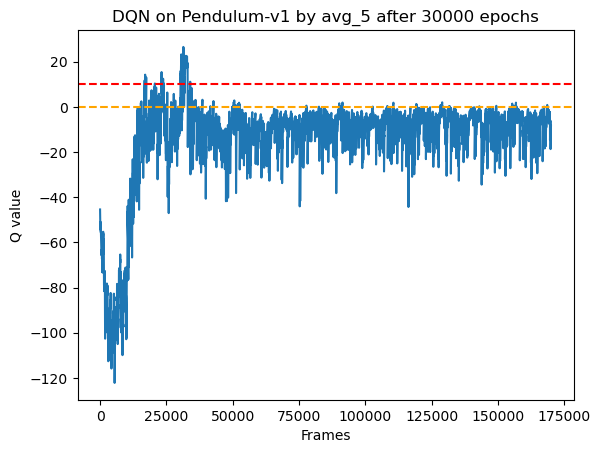

In [121]:
episodes_list = list(range(len(reward_list)))
mv_return = rl_utils.moving_average(reward_list, 5)

plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {} by avg_5'.format(env_name))
plt.show()



frames_list = list(range(len(max_q_value_list[30000:])))
plt.plot(frames_list, max_q_value_list[30000:])
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {} by avg_5 after 30000 epochs'.format(env_name))
plt.show()

## 🎉 评价

Dueling DQN的差异在网络上，网络共享一套参数（除了最后被分开的一层）。

网络有两个输出，一个是优势A，另一个是状态价值V，实际上 `A = Q - V`，即估计的Q值减去当前状态的价值V等于动作优势A，但是我们需要网络给出Q值，因此变成 `Q = V + A`. 
> 注：A和Q有两个参数`s,a`，所以叫`状态动作`优势/价值；V只有一个参数`s`，所以叫`状态`价值。

一个是V值，代表当前状态的价值，如果是一个批量，那么有两个维度，大小是(批量数, 1)；另一个是A，表示当前动作的相对优势（人为定义的），它类似传统的Q值，即给出了该状态下每个动作的Q值，如果输入的是一个批量，那么大小是(批量, 动作空间)；

在网络中需要限制A的更新，$Q = V + (A - \bar{A})$, 减去$\bar{A}$，会使得A整体更接近0，并且均值为0，这是为了减少A在梯度下降中的调整大小，从而使得梯度下降主要影响V，V的输出比较简单，也好调整一些，而改变了V，也就同时改变了所有动作的A值(运算的广播机制)，等于改变了所有动作的Q值（同时增加或者减少），因此在某个状态下的学习会对所有动作的估计产生影响，而不是只改变Q值最大的那个动作的估计。这就类似于从状态中学习价值，有的状态比较好，用什么动作都能获利，有的状态比较差，很多动作都会受损，就减小该状态下所有动作的Q值。

在前面的普通DQN和Double DQN中，没有A和V的概念，网络直接输出Q，在反向传播中，只考虑了Q值最大的那个动作，在反向传播中，就只是考虑了该动作造成的误差。